In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
import torch

%matplotlib inline

In [2]:
! tree -d ..

..
├── data
│   ├── axial
│   │   ├── train
│   │   └── valid
│   ├── coronal
│   │   ├── train
│   │   └── valid
│   └── sagittal
│       ├── models
│       ├── train
│       └── valid
└── mrnet-fastai

12 directories


In [3]:
! ls

df_abnl.pkl		 MRNet_fastai_full-pt2.ipynb  slice_stats.json
LICENSE			 MRNet_fastai_toy.ipynb       train_cases.pkl
MRNet_EDA.ipynb		 MRNet_pixel-distrib.ipynb    train_pix_distr.pkl
MRNet_fastai_full.ipynb  README.md


In [4]:
! ls ../data

axial	  train-abnormal.csv  valid-abnormal.csv
coronal   train-acl.csv       valid-acl.csv
sagittal  train-meniscus.csv  valid-meniscus.csv


In [5]:
data_path = Path('../data')
sag_path = data_path/'sagittal'
cor_path = data_path/'coronal'
ax_path = data_path/'axial'

## Substantial class imbalance for the normal/abnormal task

Given this, we'll derive weights for a weighted binary cross entropy loss function.

In [6]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(train_abnl.shape)
train_abnl.head()

(1130, 2)


,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [7]:
w = train_abnl.Abnormal.sum() / train_abnl.shape[0]
print(w)
weights = Tensor([w, 1-w])
print(weights)

0.8079646017699115
tensor([0.8080, 0.1920])


## Load previously created files

- `df_abnl` -> master `df` for use with Data Block API, also contains # of slices per series
- `slice_stats` -> `dict` stored as `json` with mean and max # of slices per series

In [8]:
df_abnl = pd.read_pickle('df_abnl.pkl')
df_abnl.head()

,Case,Abnormal,is_valid,coronal_slices,sagittal_slices,axial_slices
0,train/0000,1,0,25,27,25
1,train/0001,1,0,22,23,28
2,train/0002,1,0,24,24,24
3,train/0003,1,0,22,21,25
4,train/0004,1,0,30,30,31


In [9]:
with open('slice_stats.json', 'r') as file:
    stats = json.load(file)
    
stats

{'coronal': {'mean': 29.6416, 'max': 57},
 'sagittal': {'mean': 30.3776, 'max': 51},
 'axial': {'mean': 34.2032, 'max': 61}}

In [10]:
max_slc = stats['sagittal']['max']
print(max_slc)

51


## MRNet implementation

Modified from the original [paper](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699) to (sort of) work with `fastai`

In [119]:
class MRNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.alexnet(pretrained=pretrained)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        return torch.sigmoid(self.classifier(x))
    
    def __call__(self, x): return self.forward(x)


## Weighted binary cross entropy loss

Custom function, subclassed from `nn.Module`, to handle class imbalance

In [79]:
class WtBCELoss(nn.Module):
    def __init__(self, wts):
        super().__init__()
        self.wts = wts.float()
        
    def forward(self, output, target):
        loss = self.wts[0]*(target.float() * torch.log(output).float()) + self.wts[1]*(
                            (1-target).float() * torch.log(1-output).float())
        return torch.neg(torch.mean(loss))

## Custom data classes

- `MR3DImDataBunch` -> `ImageDataBunch` subclass with modified `one_batch` method to squeeze batches (MRNet only supports batch size of 1
- `MR3DImageList` -> `ImageList` subclass redesigned to load full image stacks from one plane/sequence and convert from `np.ndarray` to `fastai.vision` `Image` object

In [80]:
class MR3DImDataBunch(ImageDataBunch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        x = torch.squeeze(x, dim=0) # fingers crossed, this will do the trick
        return x,y


In [81]:
class MR3DImageList(ImageList):
    _bunch = MR3DImDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_slc = 51
        self.c = 1
        
    def open(self, fn):
        x = np.load(fn)
        if x.shape[0] < self.max_slc:
            x_pad = np.zeros((self.max_slc, 256, 256))
            mid = x_pad.shape[0] // 2
            up = x.shape[0] // 2
            if x.shape[0] % 2 == 1: x_pad[mid-up:mid+up+1] = x
            else: x_pad[mid-up:mid+up] = x
        else:
            x_pad = x
        return self.arr2image(np.stack([x_pad]*3, axis=1))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


## Custom Callback

Squeezes input batch

In [115]:
class MRNetCallback(Callback):
    def on_batch_begin(self, last_input, last_target, **kwargs):
        x = torch.squeeze(last_input, dim=0)
        y = last_target.float()
        return dict(last_input=x, last_target=y)


## Interim Summary

Thus far, all of the above classes/methods seem to be working well. But we still need a custom `Learner` with setup function (a la `cnn_learner`).

In [57]:
def mrnet_learner(data:DataBunch, model:Callable=MRNet(), pretrained:bool=True, init=nn.init.kaiming_normal_,
                  **kwargs:Any)->Learner:
    learn = Learner(data, model, **kwargs)
    if pretrained: learn.freeze()
#     if init: apply_init(model[1], init)
    return learn


In [83]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [84]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [85]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [86]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [87]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [88]:
# tfms = get_transforms()

In [89]:
bs = 1
data = ll.databunch(bs=bs)

In [32]:
learn = mrnet_learner(data, MRNet(), opt_func=optim.Adam, loss_func=WtBCELoss(weights),
                      callbacks=MRNetCallback(), metrics=accuracy)

AssertionError: 

In [33]:
model = MRNet()

In [34]:
model

MRNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=9216, out_features=40

In [35]:
model.model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

Picking up where we left off in the previous notebook...

We need a new `Learner` to enable splitting and freezing of our custom model.

In [90]:
layer_groups = [model.model.features, model.model.avgpool, model.model.classifier, 
                model.gap, model.classifier]

In [91]:
class MRNetLearner(Learner):
    def freeze_to(self, n:int)->None:
        "Freeze layers up to layer group `n`."
        for g in self.layer_groups[:n]:
            if is_listy(g):
                for l in g:
                    if not self.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
            else: requires_grad(g, False)    
        for g in self.layer_groups[n:]: requires_grad(g, True)
        self.create_opt(defaults.lr)

    def freeze(self)->None:
        "Freeze up to the 2nd to last layer group (i.e. gap)."
        self.freeze_to(-2)
        self.create_opt(defaults.lr)

    def unfreeze(self):
        "Unfreeze entire model."
        self.freeze_to(0)
        self.create_opt(defaults.lr)


In [100]:
def mrnet_learner(data:DataBunch, model:Callable=MRNet(), pretrained:bool=True, init=nn.init.kaiming_normal_,
                  **kwargs:Any)->Learner:
    learn = MRNetLearner(data, model, **kwargs)
    if pretrained: learn.freeze()
    if init: 
        apply_init(model.gap, init)
        apply_init(model.classifier, init)
    return learn


In [120]:
learn = mrnet_learner(data, MRNet(), opt_func=optim.Adam, loss_func=nn.BCELoss(),
                      callbacks=MRNetCallback(), metrics=accuracy, layer_groups=layer_groups)

In [121]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     True      
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    True      
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    True      
______________________________________________________________

In [122]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


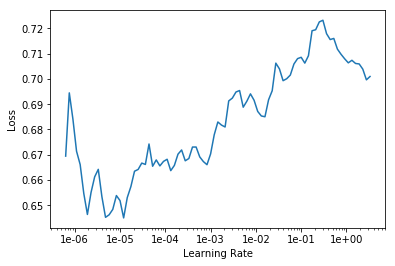

In [123]:
learn.recorder.plot()

In [124]:
learn.fit_one_cycle(5, 3e-05)

epoch,train_loss,valid_loss,accuracy,time


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/walter/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])

KeyboardInterrupt: 